# Project: Predicting Body Fat — Model Comparison & Interpretation

**Goal:** Compare several feature-selection and regularization methods under one consistent protocol, then interpret results.

## What you must do

### 1) Exploratory Data Analysis (your work)
- Make a **pairplot** for the dataset (or a sensible subset if there are many columns).
- Plot a **feature–feature correlation heatmap**.
- Plot a **bar chart of |feature–target| correlations sorted from highest to lowest**.

> Keep plots readable: titles, axis labels, sorted bars
### 2) Modeling (provided code)
We will provide code for:
- Filter (manual correlation),
- Forward selection (nested CV),
- Backward selection (nested CV),
- RidgeCV,
- LassoCV.

All use the same CV protocol and **Gap = CV R² − Test R²**.

### 3) Reporting (your work)
Produce a single comparison table with these columns:

- `Method`
- `CV R^2`
- `Test R^2`
- `Gap (CV − Test)`  ← optimism; lower is better
- `#Features`

Then write **1–2 paragraphs** that:
- Choose a “winner” and justify (accuracy, optimism gap, stability, sparsity).
- Discuss trade-offs (e.g., Ridge vs. LASSO vs. subset selection).
- Explain whether **LASSO handled multicollinearity**.

---

## Cross-validation protocol (for reference)
- `KFold(n_splits=5, shuffle=True, random_state=42)`
- Any scaling/selection is done **inside CV** (or the CV is clearly labeled as post-selection if otherwise).
- The **Gap** is always **CV R^2 − Test R^2** across methods.

---

References

Bailey, Covert (1994). Smart Exercise: Burning Fat, Getting Fit, Houghton-Mifflin Co., Boston, pp. 179-186.

Behnke, A.R. and Wilmore, J.H. (1974). Evaluation and Regulation of Body Build and Composition, Prentice-Hall, Englewood Cliffs, N.J.

Siri, W.E. (1956), "Gross composition of the body", in Advances in Biological and Medical Physics, vol. IV, edited by J.H. Lawrence and C.A. Tobias, Academic Press, Inc., New York.

Katch, Frank and McArdle, William (1977). Nutrition, Weight Control, and Exercise, Houghton Mifflin Co., Boston.

Wilmore, Jack (1976). Athletic Training and Physical Fitness: Physiological Principles of the Conditioning Process, Allyn and Bacon, Inc., Boston.

**The data were generously supplied by Dr. A. Garth Fisher who gave permission to freely distribute the data and use for non-commercial purposes.**


## Provided - DO NOT CHANGE

In [1]:
# Import required libraries
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LassoCV, Lasso
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns






## Provided - DO NOT CHANGE

In [2]:
# load the data and check if there is any missing value

try:

    bf_df = pd.read_csv('bodyfat.csv')
    
    print(f"Dataset loaded: {len(bf_df)} rows × {bf_df.shape[1]} columns")
    
    any_missing = bf_df.isnull().values.any()
    
    if any_missing:
    
        print('This data contains missing values and needs further exploration')
    
    else:
    
        print('There is no missing value')

except FileNotFoundError:
    print('File "bodyfat.csv" not found. Check if file exists in the current directory.')
except pd.errors.EmptyDataError:
    print('The file is empty or corrupted.')
except Exception as e:
    print(f'Error reading file: {e}')


Dataset loaded: 252 rows × 15 columns
There is no missing value


## Complete this block

In [14]:
# Let's drop density as it is used to calculate body fat which is our target to be predicted

bf_df = bf_df.drop('Density', axis=1)

# TO DO: Create pairplot
print("Pairplot of all features")
sns.pairplot(bf_df)


KeyError: "['Density'] not found in axis"

## EDA Interpretation — Prompts (You must answer)

 **Pairplot interpretation (___/15 pts)**
   - Identify **at least 3** clear relationships you observe (linear/non-linear, outliers).
      - There are very clear linear relationships between Hip and Weight, Abdomen and Chest, and Thigh and Hip.
   - Call out any **potential issues** visible in the plots (e.g. outliers, nonlinearity).
      - Age does not show a clear relationship with most features and instead has widely scattered data points. Similarly, height demonstrates nonlinearity, as for any given height, measurements in other categories are spread across their respective ranges. There are also several outliers, such as an individual with high weight but roughly average forearm measurements.
   - Note any variables that look **redundant** or **uninformative** from scatter patterns.
      - The age and height seem to be uninformative due to relatively uniform scattering. Some pairings like forearm & wrist, abdomen & chest, and thigh & hip seem redundant as they have very similar scatter patterns.

## Provided - DO NOT CHANGE

In [4]:
# define target (y values) and predictors (x values)

target_col = 'BodyFat'  
X = bf_df.drop(target_col, axis=1)
y = bf_df[target_col]


## Complete this block

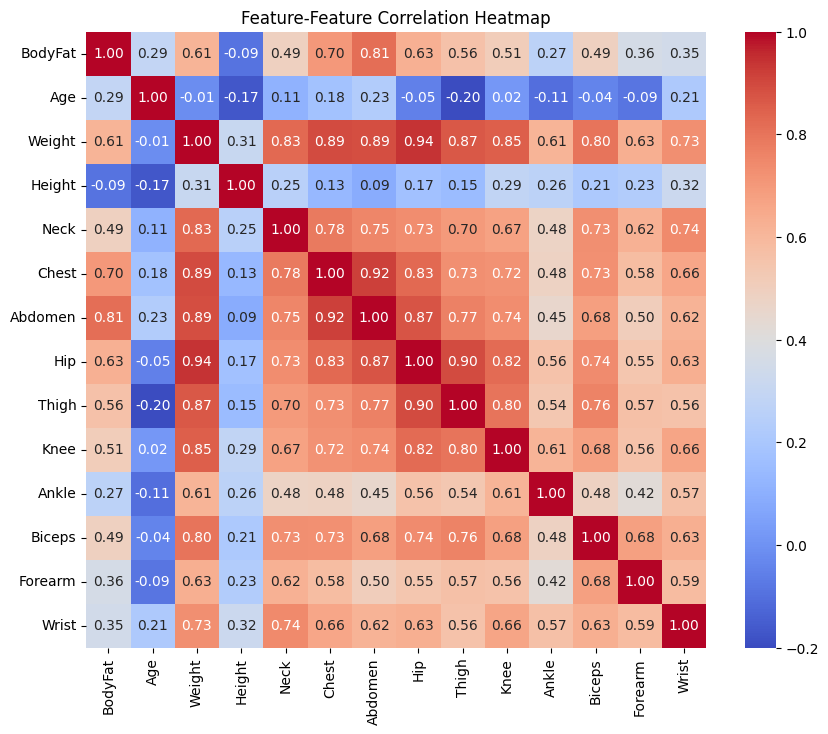

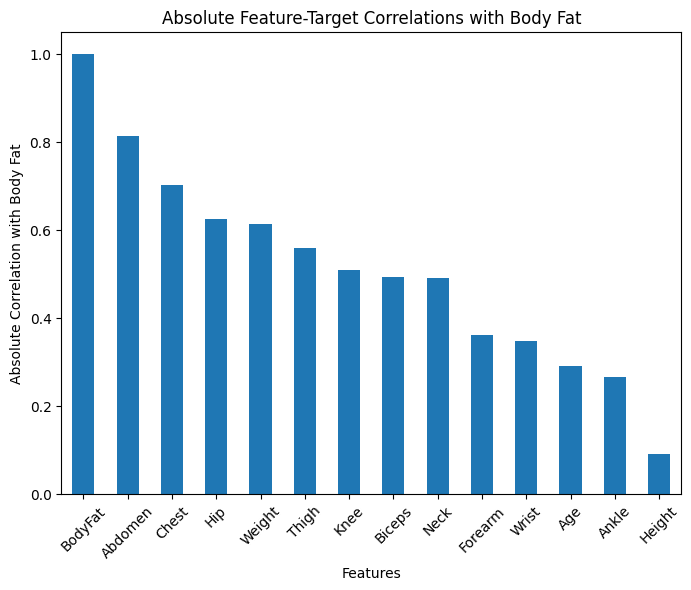

In [5]:
# TO DO: Feature-target correlations with bodyfat
ft_correlations = bf_df.corr()[target_col].abs().sort_values(ascending=False)

# TO DO: Feature-feature correlations with bodyfat
ff_correlations = bf_df.corr().abs()


# TO DO: Visualization

# To DO: Correlation heatmap
# plot a feature-feature correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = bf_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature-Feature Correlation Heatmap')
plt.show()

# To DO: Feature-target correlations
# plot a vertical bar chart of |feature-target| correlations sorted from highest to lowest
plt.figure(figsize=(8, 6))
ft_correlations.plot(kind='bar')
plt.title('Absolute Feature-Target Correlations with Body Fat')
plt.ylabel('Absolute Correlation with Body Fat')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

## EDA Interpretation — Prompts (You must answer)

1) **Feature–target correlations (___/10 pts)**
   - List the **top 5 predictors** by absolute correlation with the target (BodyFat).
      - Abdomen, Chest, Hip, Weight, Thigh
   - Explain whether the **sign and magnitude** make sense domain-wise.
      - This is expected, as larger measurements of these specific body parts generally reflect higher body fat. Height also shows a negative correlation which is reasonable since taller individuals may have proportionally less fat and more lean mass, such as bone and muscle.
2) **Feature–feature correlations (___/15 pts)**
   - Identify **at least one cluster** of highly correlated predictors.
      - Chest, abdomen, and hip cluster
   - Explain how this multicollinearity might affect **OLS**.
      - Multicollinearity can make OLS coefficient estimates unstable and sensitive to small changes in the data, which makes it difficult to interpret the effect of each variable.
   - Predict which methods (Filter/SFS/Ridge/LASSO) might **behave better/worse** under these correlations and **why**.
      - Filter would perform worse because it evaluates each feature independently and doesn't account for correlations between them.
      - SFS may still perform worse because although it considers combinations of features, it could still select redundant ones.
      - Ridge would be expected to perform better because L2 regularization stabilizes coefficient estimates when features are correlated.
      - LASSO is likely to perform better by doing feature selection, but it could possibly one select one feature from a set of correlated features, which could be difficult to interpret.


## Modeling Code (Provided) - DO NOT CHANGE

In [6]:
# SINGLE SPLIT FOR ALL METHODS - DO THIS ONCE (use random_state=42)
print("CREATING TRAIN-TEST SPLIT FOR ALL METHODS")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Features: {list(X.columns)}")
print()


CREATING TRAIN-TEST SPLIT FOR ALL METHODS
Training set: 201 samples (79.8%)
Test set: 51 samples (20.2%)
Features: ['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']



In [7]:
def _cv_r2_with_corr_ranking(X, y, k, kfold=None):
    """
    Compute mean/std CV R^2 for a linear model using a *correlation-ranked* filter.

    For each fold:
      1) Rank features by abs Pearson correlation with y on the TRAIN split only.
      2) Keep the top-k features from that ranking.
      3) Fit LinearRegression on the TRAIN split (top-k only).
      4) Predict and score R^2 on the VALIDATION split (same top-k).

    This avoids selection leakage because feature ranking is recomputed inside each fold.
    """

    # Local default splitter if none is passed
    if kfold is None:
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Ensure y is a Series aligned to X indices
    if not isinstance(y, pd.Series):
        y = pd.Series(y, index=X.index)

    scores = []
    # Loop over CV folds: tr_idx = train indices, va_idx = validation indices
    for tr_idx, va_idx in kfold.split(X):
        # Split into train/validation partitions
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        # Rank by abs Pearson corr on the *train fold only*
        corrs = X_tr.corrwith(y_tr).abs().sort_values(ascending=False)

        # Select the top-k features from this fold's ranking
        k_use = min(k, X_tr.shape[1])
        feats = corrs.head(k_use).index.tolist()

        # Fit a simple linear model on the selected features (train fold)
        m = LinearRegression().fit(X_tr[feats], y_tr)

        # Predict on the validation fold using the SAME selected features
        y_hat = m.predict(X_va[feats])

        # Compute R^2 for this fold and store it
        scores.append(r2_score(y_va, y_hat))

    # Return mean and std as plain floats
    return float(np.mean(scores)), float(np.std(scores))


def evaluate_filter_selection(X_train, y_train, X_test, y_test, max_features=13, cv_folds=5):
    """
    Filter selection using manual correlation ranking (leak-free CV).
    """
    print("METHOD 1: FILTER SELECTION (Manual Correlation)")
    print("="*50)

    n_features = X_train.shape[1]
    if max_features > n_features:
        print(f"Warning: max_features ({max_features}) > available features ({n_features})")
        max_features = n_features

    # Calculate correlations on training data only (descriptive; not used for CV)
    train_correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

    print("Absolute feature correlations with target (training data):")
    for i, (feature, corr) in enumerate(train_correlations.head(max_features).items()):
        print(f"  {i+1:2d}. {feature:<15}: {corr:.3f}")
    print()

    cv_results = []
    
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    

    for k in range(1, max_features + 1):
        # CV with per-fold correlation ranking (leak-free)
        cv_mean, cv_std = _cv_r2_with_corr_ranking(X_train, y_train, k, kfold)

        # For display only: top-k by full-train ranking (features will differ per fold)
        top_features = train_correlations.head(k).index.tolist()

        cv_results.append({
            'k': k,
            'features': top_features,   # display-only
            'cv_mean': cv_mean,
            'cv_std':  cv_std,
            'correlations': train_correlations.head(k).values
        })
        print(f"k={k:2d}: CV R^2 = {cv_mean:.4f} ± {cv_std:.4f} | Features: {top_features}")

    # Find optimal k and final evaluation
    best_result = max(cv_results, key=lambda x: x['cv_mean'])
    optimal_k = best_result['k']
    optimal_features = best_result['features']  # from full-train ranking, for final refit

    print(f"\n*** OPTIMAL FILTER MODEL ***")
    print(f"Best k: {optimal_k}")
    print(f"Selected features: {optimal_features}")

    # Final evaluation on selected features (refit on full train)
    final_model = LinearRegression().fit(X_train[optimal_features], y_train)
    train_score = final_model.score(X_train[optimal_features], y_train)
    test_score  = final_model.score(X_test[optimal_features],  y_test)

    # Use a consistent definition of gap across the notebook:
    # Gap = CV R^2 − Test R^2
    cv_score = best_result['cv_mean']
    sel_test_gap = cv_score - test_score

    print(f"Training R^2:          {train_score:.4f}")
    print(f"Test R^2:              {test_score:.4f}")
    print(f"Selection–Test gap:    {sel_test_gap:.4f}")  # CV − Test
    print(f"Train–Test gap:        {train_score - test_score:.4f}")

    return {
        'method': 'Filter Selection (Correlation)',
        'cv_results': cv_results,
        'optimal_k': optimal_k,
        'optimal_features': optimal_features,
        'train_score': float(train_score),
        'test_score': float(test_score),
        'cv_score': float(cv_score),
        'gap': float(sel_test_gap)  
    }

    


In [8]:
def evaluate_forward_selection(X_train, y_train, X_test, y_test, max_features=None, cv_folds=5, use_scaler=False):
    print("\nMETHOD 2: FORWARD SELECTION")
    print("="*50)

    n_features = X_train.shape[1]
    if max_features is None or max_features > n_features:
        max_features = n_features

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    feature_names = getattr(X_train, 'columns', [f'x{i}' for i in range(n_features)])
    cv_results = []

    # 1) try k = 1..max_features (exclusive)
    for k in range(1, max_features):
        sfs = SequentialFeatureSelector(
            LinearRegression(),
            n_features_to_select=k,
            direction="forward",
            cv=kf,
            n_jobs=-1
        )

        steps = [("sfs", sfs), ("lr", LinearRegression())]
        if use_scaler:
            steps = [("scaler", StandardScaler())] + steps

        pipe = Pipeline(steps)
        scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
        cv_results.append({"k": k, "cv_mean": scores.mean(), "cv_std": scores.std()})
        print(f"k={k:2d}: CV R^2 = {scores.mean():.4f} ± {scores.std():.4f}")

    # 2) Full model (k = n_features) WITHOUT SFS : sklearn fails to run all parameters with forward selection so add all parameters
    # here
    k_full = X_train.shape[1]
    if k_full >= 1 and max_features >= k_full:
        steps = [("lr", LinearRegression())]
    if use_scaler:
        steps = [("scaler", StandardScaler())] + steps
    pipe_full = Pipeline(steps)
    scores_full = cross_val_score(pipe_full, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
    cv_results.append({"k": k_full, "cv_mean": scores_full.mean(), "cv_std": scores_full.std()})
    print(f"k={k_full:2d}: CV R^2 = {scores_full.mean():.4f} ± {scores_full.std():.4f}  (full model)")

    # pick best k by CV R^2
    best = max(cv_results, key=lambda d: d["cv_mean"])
    optimal_k = best["k"]
    print(f"\n*** OPTIMAL FORWARD MODEL ***")
    print(f"Best k: {optimal_k}  (CV R^2 = {best['cv_mean']:.4f} ± {best['cv_std']:.4f})")

    # refit on full training to get actual selected features
    final_sfs = SequentialFeatureSelector(
        LinearRegression(),
        n_features_to_select=optimal_k,
        direction="forward",
        n_jobs=-1
    )
    if use_scaler:
        # fit scaler on train, transform before SFS fit to avoid leakage in final refit
        scaler = StandardScaler().fit(X_train)
        X_train_fit = scaler.transform(X_train)
        X_test_fit  = scaler.transform(X_test)
        final_sfs.fit(X_train_fit, y_train)
        mask = final_sfs.get_support()
        Xtr = X_train_fit[:, mask]
        Xte = X_test_fit[:,  mask]
    else:
        final_sfs.fit(X_train, y_train)
        mask = final_sfs.get_support()
        Xtr = X_train[:, mask] if not hasattr(X_train, 'loc') else X_train.iloc[:, mask]
        Xte = X_test[:,  mask] if not hasattr(X_test,  'loc') else X_test.iloc[:,  mask]

    optimal_features = [name for name, keep in zip(feature_names, mask) if keep]
    print(f"Selected features: {optimal_features}")

    # final model
    final_model = LinearRegression().fit(Xtr, y_train)
    train_r2 = final_model.score(Xtr, y_train)
    test_r2  = final_model.score(Xte, y_test)
    sel_test_gap = best["cv_mean"] - test_r2

    print(f"Training R^2:          {train_r2:.4f}")
    print(f"Test R^2:              {test_r2:.4f}")
    print(f"Selection–Test gap:    {sel_test_gap:.4f}")  # CV R^2 − Test R^2
    print(f"Train–Test gap:        {train_r2 - test_r2:.4f}")

    return {
        "method": "Forward selection (nested CV)",
        "cv_results": cv_results,
        "optimal_k": optimal_k,
        "optimal_features": optimal_features,
        "train_score": float(train_r2),
        "test_score": float(test_r2),
        "cv_score": float(best["cv_mean"]),
        "selection_test_gap": float(sel_test_gap),
        "model": final_model
    }



In [9]:
def evaluate_backward_elimination(X_train, y_train, X_test, y_test, max_features=None, cv_folds=5,use_scaler=False):
    print()
    print("METHOD 3: BACKWARD ELIMINATION")
    print("="*50)

    n_features = X_train.shape[1]
    if max_features is None or max_features > n_features:
        max_features = n_features

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    feature_names = getattr(X_train, 'columns', [f'x{i}' for i in range(n_features)])
    cv_results = []

    # ---- (A) Full model (k = n_features) without SFS ----
    if max_features >= n_features:
        steps_full = [("lr", LinearRegression())]
        if use_scaler:
            steps_full = [("scaler", StandardScaler())] + steps_full
        pipe_full = Pipeline(steps_full)
        scores_full = cross_val_score(pipe_full, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
        cv_results.append({"k": n_features, "cv_mean": scores_full.mean(), "cv_std": scores_full.std()})
        print(f"k={n_features:2d}: CV R^2 = {scores_full.mean():.4f} ± {scores_full.std():.4f}  (full model)")


    
    # ---- (B) Backward SFS for k = max_features-1 down to 1 ----
    upper_k = min(max_features - 1, n_features - 1)
    for k in range(upper_k, 0, -1):
        sfs = SequentialFeatureSelector(
            LinearRegression(),
            n_features_to_select=k,
            direction="backward",
            cv=kf,
            n_jobs=-1
        )
        steps = [("sfs", sfs), ("lr", LinearRegression())]
        if use_scaler:
            steps = [("scaler", StandardScaler())] + steps
        pipe = Pipeline(steps)

        scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
        cv_results.append({"k": k, "cv_mean": scores.mean(), "cv_std": scores.std()})
        print(f"k={k:2d}: CV R^2 = {scores.mean():.4f} ± {scores.std():.4f}")


    
    
    # Pick best k by mean CV R^2
    best = max(cv_results, key=lambda d: d["cv_mean"])
    optimal_k = best["k"]

    print(f"\n*** OPTIMAL BACKWARD MODEL ***")
    print(f"Best k: {optimal_k}  (CV R^2 = {best['cv_mean']:.4f} ± {best['cv_std']:.4f})")

    if optimal_k < n_features:
        final_sfs = SequentialFeatureSelector(
            LinearRegression(),
            n_features_to_select=optimal_k,
            direction="backward",
            n_jobs=-1
        )
        if use_scaler:
            scaler = StandardScaler().fit(X_train)
            Xtr_all = scaler.transform(X_train)
            Xte_all = scaler.transform(X_test)
            final_sfs.fit(Xtr_all, y_train)
            mask = final_sfs.get_support()
            Xtr = Xtr_all[:, mask]
            Xte = Xte_all[:,  mask]
        else:
            final_sfs.fit(X_train, y_train)
            mask = final_sfs.get_support()
            Xtr = X_train.iloc[:, mask] if hasattr(X_train, 'iloc') else X_train[:, mask]
            Xte = X_test.iloc[:,  mask] if hasattr(X_test,  'iloc') else X_test[:,  mask]
        optimal_features = [name for name, keep in zip(feature_names, mask) if keep]
    else:
        # Full model: all features, no SFS
        if use_scaler:
            scaler = StandardScaler().fit(X_train)
            Xtr = scaler.transform(X_train)
            Xte = scaler.transform(X_test)
        else:
            Xtr, Xte = X_train, X_test
        optimal_features = list(feature_names)

    final_model = LinearRegression().fit(Xtr, y_train)
    train_r2 = final_model.score(Xtr, y_train)
    test_r2  = final_model.score(Xte, y_test)
    cv_score = float(best["cv_mean"])
    gap = cv_score - test_r2  # unified definition: CV − Test

    print(f"Selected features: {optimal_features}")
    print(f"Training R^2:          {train_r2:.4f}")
    print(f"Test R^2:              {test_r2:.4f}")
    print(f"Selection–Test gap:    {gap:.4f}")
    print(f"Train–Test gap:        {train_r2 - test_r2:.4f}")

    return {
        "method": "Backward selection (nested CV)",
        "cv_results": cv_results,
        "optimal_k": optimal_k,
        "optimal_features": optimal_features,
        "train_score": float(train_r2),
        "test_score": float(test_r2),
        "cv_score": cv_score,
        "gap": float(gap),
        "model": final_model
    }

    
    


In [10]:
def evaluate_ridge_selection(X_train, y_train, X_test, y_test, cv_folds=5, use_scaler=False):
    """Ridge regression with same evaluation framework."""
    print("\nMETHOD 4: RIDGE REGRESSION")
    print("="*50)

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Wider, standard grid for ridge
    alpha_values = np.logspace(-4, 4, 200)

    # RidgeCV to choose alpha*
    if use_scaler:
        pipe_cv = Pipeline([
            ("scaler", StandardScaler()),
            ("ridgecv", RidgeCV(alphas=alpha_values, cv=kf, scoring='r2'))
        ])
        pipe_cv.fit(X_train, y_train)
        optimal_alpha = pipe_cv.named_steps["ridgecv"].alpha_
        # Evaluate CV R^2 at alpha* with same scaling
        pipe_eval = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=optimal_alpha))
        ])
    else:
        ridge_cv = RidgeCV(alphas=alpha_values, cv=kf, scoring='r2')
        ridge_cv.fit(X_train, y_train)
        optimal_alpha = ridge_cv.alpha_
        pipe_eval = Ridge(alpha=optimal_alpha)

    # CV mean/std at chosen alpha*
    cv_scores = cross_val_score(pipe_eval, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
    cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())

    print(f"Tested alpha values: logspace(-4, 4) [{len(alpha_values)} points]")
    print(f"Optimal alpha: {optimal_alpha:.6g}")
    print(f"CV R^2 (mean ± std): {cv_mean:.4f} ± {cv_std:.4f}")

    # Final fit and test score
    pipe_eval.fit(X_train, y_train)
    train_score = pipe_eval.score(X_train, y_train)
    test_score  = pipe_eval.score(X_test,  y_test)

    # Consistent gap definition across notebook
    gap = cv_mean - test_score

    print(f"Training R^2:          {train_score:.4f}")
    print(f"Test R^2:              {test_score:.4f}")
    print(f"Selection–Test gap:    {gap:.4f}")  # CV − Test
    print(f"Train–Test gap:        {train_score - test_score:.4f}")

    # Coefficients (only if no scaler or if you inverse-transform manually)
    if not use_scaler:
        coef = pipe_eval.coef_
        coef_df = pd.DataFrame({
            'Feature': getattr(X_train, 'columns', [f'x{i}' for i in range(X_train.shape[1])]),
            'Coefficient': coef,
            'Abs_Coefficient': np.abs(coef)
        }).sort_values('Abs_Coefficient', ascending=False)
        print("\nCoefficient magnitudes (no scaling applied):")
        print(coef_df.to_string(index=False))
    else:
        print("\n(Info) Coefficients not printed because scaling is applied in the pipeline; "
              "raw coefficients aren’t directly comparable without inverse scaling.")

    return {
        'method': 'Ridge Regression (CV)',
        'optimal_alpha': float(optimal_alpha),
        'optimal_features': list(getattr(X_train, 'columns', [f'x{i}' for i in range(X_train.shape[1])])),  # Ridge keeps all
        'train_score': float(train_score),
        'test_score': float(test_score),
        'cv_score': float(cv_mean),
        'cv_std': float(cv_std),
        'gap': float(gap),                   # <-- unified gap (CV − Test)
        'n_features': int(X_train.shape[1]),
        'model': pipe_eval                   # fitted final estimator (Pipeline or Ridge)
    }


In [11]:
def evaluate_lasso_selection(X_train, y_train, X_test, y_test, cv_folds=5, use_scaler=False):
    """LASSO regression with proper CV scoring. Set use_scaler=True if X isn't pre-standardized."""
    print("\nMETHOD 5: LASSO REGRESSION")
    print("="*50)

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    alphas = np.logspace(-4, 1, 100)

    if use_scaler:
        # Choose alpha* with scaling inside CV
        lasso_cv = Pipeline([
            ("scaler", StandardScaler()),
            ("lassocv", LassoCV(alphas=alphas, cv=kf, max_iter=10000))
        ])
        lasso_cv.fit(X_train, y_train)
        optimal_alpha = float(lasso_cv.named_steps["lassocv"].alpha_)

        # Evaluate CV R^2 at alpha* (with same scaling)
        eval_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("lasso", Lasso(alpha=optimal_alpha, max_iter=10000))
        ])
        cv_scores = cross_val_score(eval_pipe, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
        cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())

        # Final fit for train/test scores
        eval_pipe.fit(X_train, y_train)
        train_r2 = float(eval_pipe.score(X_train, y_train))
        test_r2  = float(eval_pipe.score(X_test,  y_test))

        # --- Recover ORIGINAL-SCALE coefficients from the fitted pipeline ---
        feature_names = getattr(X_train, 'columns', [f'x{i}' for i in range(X_train.shape[1])])
        scaler = eval_pipe.named_steps["scaler"]
        lasso  = eval_pipe.named_steps["lasso"]
    
        w_std = lasso.coef_          # coefficients on standardized X
        b_std = lasso.intercept_     # intercept on standardized X
        mu    = scaler.mean_
        sigma = scaler.scale_
    
        # Guard against zero variance features (shouldn't happen if you pre-clean)
        eps = 1e-12
        sigma_safe = np.where(np.abs(sigma) < eps, 1.0, sigma)
    
        # Map back to original feature scale
        coef_orig      = w_std / sigma_safe
        intercept_orig = b_std - np.sum(mu * coef_orig)
    
        # Nonzero mask / selected features (same zeros on scaled & original)
        tol = 1e-8
        non_zero_mask   = ~np.isclose(w_std, 0.0, atol=tol)
        non_zero_coefs  = int(non_zero_mask.sum())
        selected_features = [n for n, keep in zip(feature_names, non_zero_mask) if keep]
    
        
        print("\nOriginal-scale coefficients (after inverting StandardScaler):")
        print(f"  intercept: {intercept_orig: .6f}")
        for name, c in zip(feature_names, coef_orig):
            print(f"  {name:<20}: {c: .6f}")
    
        
        model_to_return = eval_pipe

    else:
        # No scaler; X must already be standardized
        lasso_cv = LassoCV(alphas=alphas, cv=kf, max_iter=10000)
        lasso_cv.fit(X_train, y_train)
        optimal_alpha = float(lasso_cv.alpha_)

        # CV at alpha*
        cv_scores = cross_val_score(
            Lasso(alpha=optimal_alpha, max_iter=10000),
            X_train, y_train, cv=kf, scoring='r2', n_jobs=-1
        )
        cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())

        # Train/Test
        train_r2 = float(lasso_cv.score(X_train, y_train))
        test_r2  = float(lasso_cv.score(X_test,  y_test))

        # Coefficients & selected features
        tol = 1e-8
        coefs = lasso_cv.coef_
        non_zero_mask = ~np.isclose(coefs, 0.0, atol=tol)
        non_zero_coefs = int(non_zero_mask.sum())
        feature_names = getattr(X_train, 'columns', [f'x{i}' for i in range(X_train.shape[1])])
        selected_features = [n for n, keep in zip(feature_names, non_zero_mask) if keep]

        print(f"\nCoefficients (alpha={optimal_alpha:.6g}):")
        for f, c in zip(feature_names, coefs):
            print(f"  {f:<20}: {c: .6f}")

        model_to_return = lasso_cv

    gap = cv_mean - test_r2  # unified: CV − Test

    print(f"Optimal alpha:         {optimal_alpha:.6f}")
    if non_zero_coefs is not None:
        print(f"Features selected:     {non_zero_coefs}/{X_train.shape[1]}")
        print(f"Selected features:     {selected_features}")
    print(f"CV R^2 (mean ± std):   {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"Training R^2:          {train_r2:.4f}")
    print(f"Test R^2:              {test_r2:.4f}")
    print(f"Selection–Test gap:    {gap:.4f}")
    print(f"Train–Test gap:        {train_r2 - test_r2:.4f}")

    return {
    'method': 'Lasso Regression (CV)',
    'optimal_alpha': optimal_alpha,
    'optimal_features': selected_features,
    'train_score': train_r2,
    'test_score': test_r2,
    'cv_score': cv_mean,
    'cv_std': cv_std,
    'gap': cv_mean - test_r2,
    'n_features': non_zero_coefs,
    'model': model_to_return,
    'coef_scaled': w_std,                 # optional: for debugging
    'coef_original': coef_orig,           # original-scale betas
    'intercept_original': float(intercept_orig)
    }


    
    


## Genarte a summary table and anlayze your result

In [12]:
# Run all methods on same train-test split
all_results = []

# Method 1: Filter Selection
filter_results = evaluate_filter_selection(X_train, y_train, X_test, y_test)
all_results.append(filter_results)

# Method 2: Forward Selection  
forward_results = evaluate_forward_selection(X_train, y_train, X_test, y_test)
all_results.append(forward_results)

# Method 3: Backward Elimination
backward_results = evaluate_backward_elimination(X_train, y_train, X_test, y_test)
all_results.append(backward_results)

# Method 4: Ridge
ridge_results = evaluate_ridge_selection(X_train, y_train, X_test, y_test,use_scaler=True)
all_results.append(ridge_results)

# Method 5: LASSO
lasso_results = evaluate_lasso_selection(X_train, y_train, X_test, y_test,use_scaler=True)
all_results.append(lasso_results)


METHOD 1: FILTER SELECTION (Manual Correlation)
Absolute feature correlations with target (training data):
   1. Abdomen        : 0.831
   2. Chest          : 0.712
   3. Hip            : 0.651
   4. Weight         : 0.638
   5. Thigh          : 0.560
   6. Neck           : 0.517
   7. Biceps         : 0.515
   8. Knee           : 0.505
   9. Forearm        : 0.378
  10. Wrist          : 0.369
  11. Ankle          : 0.307
  12. Age            : 0.291
  13. Height         : 0.093

k= 1: CV R^2 = 0.6707 ± 0.0495 | Features: ['Abdomen']
k= 2: CV R^2 = 0.6897 ± 0.0465 | Features: ['Abdomen', 'Chest']
k= 3: CV R^2 = 0.7152 ± 0.0385 | Features: ['Abdomen', 'Chest', 'Hip']
k= 4: CV R^2 = 0.7074 ± 0.0337 | Features: ['Abdomen', 'Chest', 'Hip', 'Weight']
k= 5: CV R^2 = 0.7067 ± 0.0352 | Features: ['Abdomen', 'Chest', 'Hip', 'Weight', 'Thigh']
k= 6: CV R^2 = 0.7106 ± 0.0340 | Features: ['Abdomen', 'Chest', 'Hip', 'Weight', 'Thigh', 'Neck']
k= 7: CV R^2 = 0.7091 ± 0.0271 | Features: ['Abdomen', '

In [13]:
# TO DO : Final comparison,  Generate a table with following columns: 
# Method, Cross Validation R^2 Score, Test R^2 Score, gap value, and number of features selected 
# by each method (Filter Selection, Forward selection, Backward selection, Ridge Regression, Lasso Regression)

df_summary = pd.DataFrame(all_results)

# find gap and number of selected features
df_summary['Gap Value'] = df_summary['cv_score'] - df_summary['test_score']
df_summary['Number of Features Selected'] = df_summary['optimal_features'].apply(len)

# select columns
df_summary = df_summary[['method', 'cv_score', 'test_score', 'Gap Value', 'Number of Features Selected']]
df_summary.columns = ['Method', 'Cross Validation R^2 Score', 'Test R^2 Score', 'Gap Value', 'Number of Features Selected']

df_summary

,Method,Cross Validation R^2 Score,Test R^2 Score,Gap Value,Number of Features Selected
0,Filter Selection (Correlation),0.715236,0.509348,0.205888,3
1,Forward selection (nested CV),0.719710,0.605061,0.114650,3
2,Backward selection (nested CV),0.716063,0.512996,0.203066,6
3,Ridge Regression (CV),0.703362,0.612576,0.090787,13
4,Lasso Regression (CV),0.705922,0.551491,0.154431,5


## Model Comparison & Reporting — Grading

### 1) Model comparison table — **/20**
**Deliverable:** One table summarizing each method with:
- `Method`
- `CV R^2`
- `Test R^2`
- `Gap (CV − Test)`
- `#Features`

---

### 2) Final recommendation & trade-offs — **/20**
**Deliverable:** A 1–2 paragraph justification that:
- Chooses a “best” model and explains **why** (Test R^2, Gap, stability, sparsity).
- Discusses **trade-offs** (e.g., Ridge accuracy/stability vs. LASSO sparsity; subset selection overfitting).
- Connects back to EDA insights where relevant (e.g., correlated clusters, method behavior).

The "best" model here is Ridge Regression because, while it has a similar CV R^2 value as the other models, it has the highest Test R^2 value (0.612576) and the lowest CV-Test gap (0.090787). This means that the model is stable and generalizes well to unseen data. The main trade-off is that Ridge retains all 13 predictors, so the model is not sparse like LASSO, which in this case only keeps 5 predictors. LASSO can zero out less important features, making interpreting easier, but it can also be unstable when predictors are highly correlated. On the other hand, subset selection carries a higher risk of overfitting to the training data because it chooses features based on R^2. We can see this from the large gap value for the forward and backward selection methods. Overall, ridge regression handles multicollinearity well by shrinking the coefficients of correlated variables. For example, it was able to handle the clusters of correlated features observed in the EDA for the hip, chest, and abdomen measurements.

---

### 3) LASSO & collinearity (nuanced answer) — **/10**
**Deliverable:** A short explanation addressing:
- How **LASSO (L1)** behaves with correlated predictors.
- How **Ridge (L2)** differs.
- Conclusion: whether LASSO “handled” collinearity **in this dataset**, with evidence (selected features/coeffs).

    - LASSO (L1) tends to select one predictor among a group of highly correlated variables and shrink the rest to zero. This can simplify the model and help with interpretation, but the choice of which predictor is kept is usually unstable when predictors are strong correlated.
    - Ridge (L2) shrinks coefficients of correlated predictors together rather than eliminating them. They retain all predictors and distribute the effect across correlated variables, which is generally more stable when there is multicollinearity.
    - In this dataset, LASSO did not handle collinearity well. It dropped the coefficients of 8 predictors to 0, and retaining only 5. For example, it selected abdomen and wrist as representatives of their correlated feature clusters, and created a relatively large gap value of 0.203066, more than twice the gap observed for Ridge.

---

### 4) Reproducibility & presentation — **/5**
**Deliverable:** Polished, reproducible notebook:
- Plots have titles/labels; tables are readable.
- Notebook runs **top-to-bottom** without edits or errors.

---
